# **Sign Language Recognition** : BARAT ( *bahasa isyarat* )

In [ ]:
!pip install tensorflowjs

In [1]:
!rm -rf "sample_data"

In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print('Using TensorFlow Version:', tf.__version__)

Using TensorFlow Version: 2.12.0


## Download and Inspect the Dataset

upload your kaggle token

In [3]:
from google.colab import files

print("upload your kaggle token [ kaggle.json ]\n")
uploaded = files.upload()

upload your kaggle token [ kaggle.json ]



Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d mlanangafkaar/datasets-lemlitbang-sibi-alphabets

100% 1.75G/1.75G [01:47<00:00, 15.7MB/s]
100% 1.75G/1.75G [01:47<00:00, 17.5MB/s]


extract dataset to /tmp

In [5]:
zip_ref = zipfile.ZipFile('./datasets-lemlitbang-sibi-alphabets.zip', 'r')
zip_ref.extractall('/tmp/datasets-lemlitbang-sibi-alphabets')
zip_ref.close()

In [6]:
# Move dataset raw dataset to /content/SIBI_RAW
!mv /tmp/datasets-lemlitbang-sibi-alphabets/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/ /content/SIBI_RAW
!rm -rf /tmp/datasets-lemlitbang-sibi-alphabets

# Deletes all non-image files from dataset
!find /content/SIBI_RAW -type f ! -name "*.jpg" -exec rm {} +


In [7]:
from keras.utils import load_img, img_to_array

def plot_image(file_location):
  img = load_img(file_location)
  img_arr = img_to_array(img)

  print(f"Gambar ini memiliki shape {img_arr.shape}\n")
  img = mpimg.imread(file_location)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

Gambar ini memiliki shape (2000, 2000, 3)



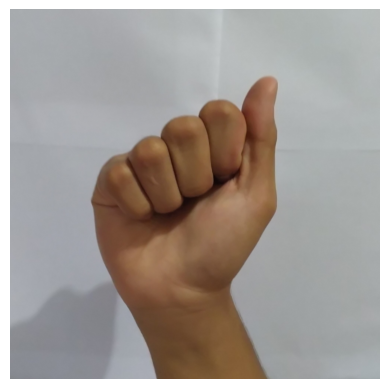

In [8]:
plot_image('./SIBI_RAW/training/A/A_1.jpg')

## Creating the generators for the CNN

In [21]:
from keras.preprocessing.image import ImageDataGenerator

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator( rescale = 1.0/255. )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=20,
      class_mode='sparse',
      target_size=(150, 150)
  )

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=20,
      class_mode='sparse',
      target_size=(150, 150)
  )

  return train_generator, validation_generator

In [22]:
TRAINING_DIR = "/content/SIBI_RAW/training/"
VALIDATION_DIR = "/content/SIBI_RAW/validation/"

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 468 images belonging to 26 classes.
Found 52 images belonging to 26 classes.


## Coding the CNN

In [23]:
class CustomCallback(tf.keras.callbacks.Callback):
  # Define the correct function signature for on_epoch_end
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.99:
      print("\nReached 99% accuracy so cancelling training!")
      # Stop training once the above condition is met
      self.model.stop_training = True

In [24]:
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
  ])

  # Set the training parameters
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [25]:
# Get the untrained model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 17, 17, 64)      

In [26]:
# Train the model, this may take some time.
callbacks = CustomCallback()

history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/100
24/24 [==============================] - 36s 1s/step - loss: 3.2704 - accuracy: 0.0278 - val_loss: 3.2579 - val_accuracy: 0.0385
Epoch 2/100
24/24 [==============================] - 30s 1s/step - loss: 3.2577 - accuracy: 0.0470 - val_loss: 3.2492 - val_accuracy: 0.0769
Epoch 3/100
24/24 [==============================] - 32s 1s/step - loss: 3.1495 - accuracy: 0.0855 - val_loss: 2.9555 - val_accuracy: 0.1923
Epoch 4/100
24/24 [==============================] - 30s 1s/step - loss: 2.4297 - accuracy: 0.2735 - val_loss: 2.0672 - val_accuracy: 0.3654
Epoch 5/100
24/24 [==============================] - 32s 1s/step - loss: 1.7011 - accuracy: 0.4701 - val_loss: 1.7767 - val_accuracy: 0.4808
Epoch 6/100
24/24 [==============================] - 30s 1s/step - loss: 0.9939 - accuracy: 0.6709 - val_loss: 1.2671 - val_accuracy: 0.6538
Epoch 7/100
24/24 [==============================] - 30s 1s/step - loss: 0.7023 - accuracy: 0.7949 - val_loss: 1.0393 - val_accuracy: 0.6154
Epoch 8/100
2

In [27]:
def plot_history(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'], c='r')
  plt.plot(history.history['val_accuracy'], c='b')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'], c='r')
  plt.plot(history.history['val_loss'], c='b')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

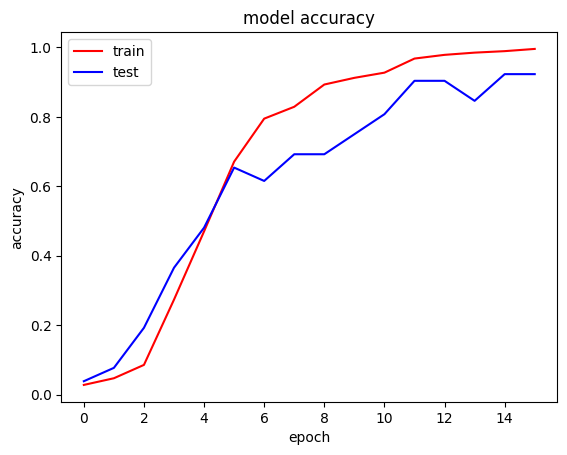

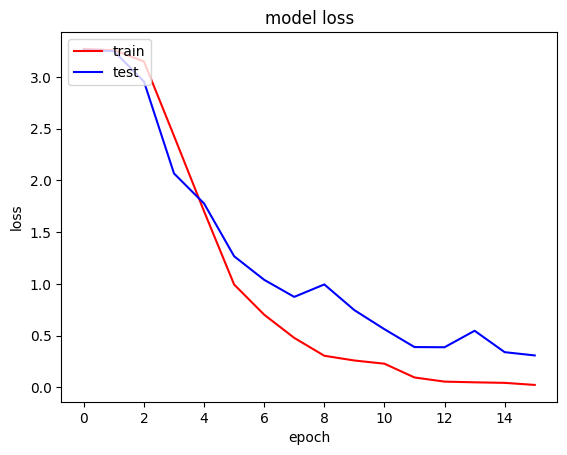

In [28]:
plot_history(history)

## Testing

Testing with upload File

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

testing from local file

In [29]:
path = '/content/SIBI_RAW/test/S (3).jpg'
img = load_img(path, target_size=(150, 150))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# print(fn)
print(classes)

1/1 [==============================] - 0s 90ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0.]]


## Save Model

### save history

In [30]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### save model .h5

In [31]:
# import time
# saved_model_path = "./{}.h5".format(int(time.time()))

saved_model_path = "./model_barat.h5"

model.save(saved_model_path)
# files.download(saved_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### save model .json

In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./json-model

### save to TFLite

In [34]:
#Load model h5
# model = tf.keras.models.load_model(filepath="model_barat.h5")

# Convert model h5
konversi = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite = konversi.convert()

#Simpan model yang sudah diconvert
with tf.io.gfile.GFile('model_barat.tflite', 'wb') as f:
  f.write(model_tflite)